# Input Update Benchmark Notebook
This notebook runs the input update benchmark for ParquetDB
across various input data types and row counts, then plots the results.


---

## Benchmark Details

- **Data Generation:**  
  - 1,000,000 rows &times; 100 columns of integers (0–1,000,000).  
  - Integers chosen as a basic primitive type—benchmark times here represent a **lower bound** on update performance; more complex or larger types will incur higher costs (due to larger byte sizes).

- **Parquet Normalization Settings (defaults):**  
  - **Row groups:** minimum 50,000–100,000 rows per group  
  - **File size cap:** maximum 10,000,000 rows per file  
  - You can tune these settings (e.g. smaller row groups or larger file limits) to trade off update vs. read performance.

---

## System Specifications

- **Operating System:** Windows 10  
- **Processor:** AMD Ryzen 7 3700X 8‑Core @ 3.6 MHz (8 cores, 16 logical processors)  
- **Memory:** 128 GB DDR4‑3600 MHz (4×32 GB DIMMs) 
- **Storage**: SATA HDD 2TB (Model: ST2000DM008-2FR102)

---

## 1. Setup
Import required libraries and set up paths.

In [ ]:
!pip install parquetdb

In [1]:
import os
import time
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pyarrow as pa
from parquetdb import ParquetDB, config
from parquetdb.utils import general_utils

# Set up data directory
bench_dir= os.path.join(config.data_dir, 'benchmarks')
save_dir = os.path.join(bench_dir, 'parquetdb')
os.makedirs(save_dir, exist_ok=True)
db_path = os.path.join(save_dir, 'BenchmarkDB')


## 2. Initialize Database
Remove any existing database and create a fresh one with 1M rows of random data.

In [2]:
# Remove existing DB
if os.path.exists(db_path):
    shutil.rmtree(db_path)

# Initialize and populate
db = ParquetDB(db_path=db_path)
data = general_utils.generate_pydict_data(
    n_rows=1_000_000, n_columns=100, min_value=0, max_value=1_000_000
)
db.create(data)
del data, db


[INFO] 2025-04-19 11:26:40 - parquetdb.core.parquetdb[205][__init__] - Initializing ParquetDB with db_path: Z:\data\parquetdb\data\benchmarks\parquetdb\BenchmarkDB
[INFO] 2025-04-19 11:26:40 - parquetdb.core.parquetdb[207][__init__] - verbose: 1


## 3. Run Input Update Benchmark
Benchmark update performance for different input types and row counts.

In [3]:
# Benchmark parameters
row_counts = [1, 10, 100, 1_000, 10_000, 100_000, 1_000_000]
input_types = ['pydict', 'pylist', 'pandas', 'table']

# Storage for results
results = {
    'input_data_type': [],
    'n_rows': [],
    'update_times': []
}

for n in row_counts:
    # generate update table
    table = general_utils.generate_table_update_data(
        n_rows=n, n_columns=100
    )
    for itype in input_types:
        db = ParquetDB(db_path=db_path)
        # prepare input
        if itype == 'pydict':
            update_data = table.to_pydict()
        elif itype == 'pylist':
            update_data = table.to_pylist()
        elif itype == 'pandas':
            update_data = table.to_pandas()
        else:
            update_data = table

        # run update
        start = time.perf_counter()
        db.update(update_data)
        elapsed = time.perf_counter() - start
        # record
        results['input_data_type'].append(itype)
        results['n_rows'].append(n)
        results['update_times'].append(elapsed)

        print(f'Input={itype}, rows={n}, time={elapsed:.4f}s')
        del update_data, db

# save results
df = pd.DataFrame(results)
csv_path = os.path.join(save_dir, 'parquetdb_input_update_benchmark.csv')
df.to_csv(csv_path, index=False)
print('Benchmark results saved to', csv_path)

Input=pydict, rows=1, time=9.9136s
Input=pylist, rows=1, time=9.4008s
Input=pandas, rows=1, time=9.5054s
Input=table, rows=1, time=9.4650s
Input=pydict, rows=10, time=9.5665s
Input=pylist, rows=10, time=9.4898s
Input=pandas, rows=10, time=9.8546s
Input=table, rows=10, time=9.0859s
Input=pydict, rows=100, time=9.4329s
Input=pylist, rows=100, time=10.9167s
Input=pandas, rows=100, time=9.4779s
Input=table, rows=100, time=9.9870s
Input=pydict, rows=1000, time=9.5006s
Input=pylist, rows=1000, time=9.0437s
Input=pandas, rows=1000, time=8.5357s
Input=table, rows=1000, time=9.2891s
Input=pydict, rows=10000, time=8.3776s
Input=pylist, rows=10000, time=9.3234s
Input=pandas, rows=10000, time=9.1188s
Input=table, rows=10000, time=9.2263s
Input=pydict, rows=100000, time=9.9234s
Input=pylist, rows=100000, time=11.9785s
Input=pandas, rows=100000, time=9.4006s
Input=table, rows=100000, time=9.3413s
Input=pydict, rows=1000000, time=14.9886s
Input=pylist, rows=1000000, time=32.1442s
Input=pandas, rows=1

## 4. Load and Preview Results

In [3]:
csv_path = os.path.join(save_dir, 'parquetdb_input_update_benchmark.csv')
df = pd.read_csv(csv_path)
df.head()

,input_data_type,n_rows,update_times
0,pydict,1,9.913610
1,pylist,1,9.400836
2,pandas,1,9.505378
3,table,1,9.465031
4,pydict,10,9.566514


## 5. Plot Update Times
Plot update times vs. number of rows for each input type, including a log-log inset.

C:\Users\lllang\AppData\Local\Temp\ipykernel_22152\1546944237.py:60: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


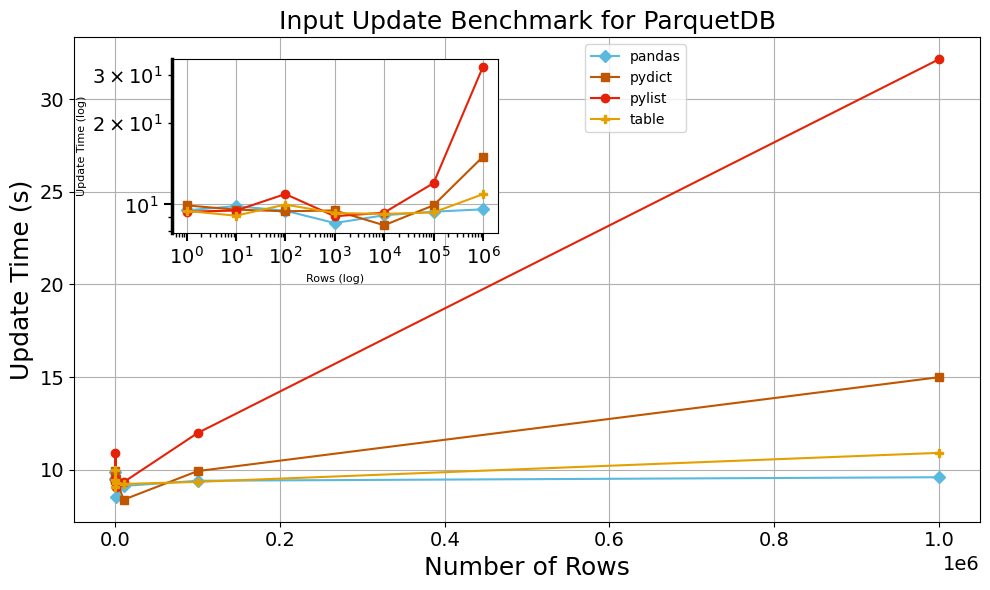

In [5]:
# Plot style settings
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14

# Prepare plot
fig, ax = plt.subplots(figsize=(10, 6))

# Color and marker maps
colors = {'pydict': '#c05600', 'pylist': '#e52207', 'pandas': '#59b9de', 'table': '#e5a000'}
markers = {'pydict': 's', 'pylist': 'o', 'pandas': 'D', 'table': 'P'}

# Main plot
handles = []
for key, grp in df.groupby('input_data_type'):
    h, = ax.plot(
        grp['n_rows'], grp['update_times'],
        label=key, color=colors[key], marker=markers[key], linestyle='solid'
    )
    handles.append(h)

ax.set_xlabel('Number of Rows')
ax.set_ylabel('Update Time (s)')
ax.grid(True)

# Inset axes
ax_in = inset_axes(ax, width='36%', height='36%', loc='upper left',
                   bbox_to_anchor=(0.1, -0.03, 1, 1), bbox_transform=ax.transAxes)
for key, grp in df.groupby('input_data_type'):
    ax_in.plot(
        grp['n_rows'], grp['update_times'],
        color=colors[key], marker=markers[key], linestyle='solid'
    )
ax_in.set_xscale('log')
ax_in.set_yscale('log')

nticks = 9
maj_loc = ticker.LogLocator(numticks=nticks)
min_loc = ticker.LogLocator(subs="all", numticks=nticks)
ax_in.xaxis.set_major_locator(maj_loc)
ax_in.xaxis.set_minor_locator(min_loc)

# Set the same linestyle and make the spine thicker for visibility
ax_in.spines["left"].set_linestyle("solid")
ax_in.spines["left"].set_linewidth(2.5)  # Increase the line width for visibility

ax_in.tick_params(
    axis="both", which="major", length=6, width=1.5, direction="out"
)
ax_in.tick_params(axis="x", which="minor", length=3, width=1, direction="out")
ax_in.tick_params(axis="y", which="minor", length=3, width=1, direction="out")

ax_in.set_xlabel('Rows (log)', fontsize=8)
ax_in.set_ylabel('Update Time (log)', fontsize=8)
ax_in.grid(True)

ax.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.12, 0, 1, 1))
ax.set_title('Input Update Benchmark for ParquetDB')
plt.tight_layout()
plt.savefig(os.path.join(bench_dir,"input-type-update_benchmark.pdf"))
plt.show()

## 6. Dicussion


1. **Preprocessing cost dominates**  
   - Every update run spends the bulk of its time converting the input into a PyArrow‐compatible table before the actual write occurs. As a result, raw I/O and compute on the Parquet side are a small fraction of the total.

2. **Input format matters**  
   - **`pylist` (list of dicts)** is by far the slowest—its untyped, row‐oriented structure forces Python to rebuild every column from scratch, yielding linear growth up to ~30 s at 1 M rows.  
   - **`pydict` (dict of column lists)** improves on that by keeping each column contiguous in memory, but still pays a field‐by‐field conversion cost, rising from ~9 s to ~15 s.  
   - **`pandas.DataFrame`** and **`pyarrow.Table`** inputs are essentially “zero‐copy” (or very low‐overhead) for Arrow ingestion: they start at ~8.5 s and only tick up to ~9.7 s even at 1 M rows.

3. **Key takeaway**  
   - For batch updates of large tables, feeding ParquetDB with **columnar inputs** (Pandas or native PyArrow tables) is critical to minimizing pre‑processing latency. Row‑oriented Python structures will quickly become the bottleneck.

